Installed packages in virtual environment

In [ ]:
# %pip install pymongo
# %pip install pandas (will install numpy)
# %pip install google-cloud-bigquery
# %pip install seaborn

In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

## 1. init connection to database
- Create 2 collections: business, reviews
- upload json files into their respective collections

In [2]:
client = MongoClient()
client = MongoClient('localhost', 27017)

In [3]:
yelp_db = client["Yelp_dataset"] 
business_collection = yelp_db['business'] 
review_collection = yelp_db['reviews']

## 2. Initialise tables

Currently, we need 4 tables
- Business table: { Business_id (PK) , Name , State, City , Stars, Review_count, weighted_review, Categories }
- Names table : {Name (PK) , Number of outlets, Average reviews , Total reviews} 
- Reviews table {Review_id (PK), Business_id (FK), Stars, Text}
- Categories table : {Category, Count (number of appearance), score (avg)}




TODO: calculate weighted reviews: https://medium.com/district-data-labs/computing-a-bayesian-estimate-of-star-rating-means-651496a890ab
https://www.codementor.io/@arpitbhayani/solving-an-age-old-problem-using-bayesian-average-15fy4ww08p#cumulative-rating 
https://www.algolia.com/doc/guides/managing-results/must-do/custom-ranking/how-to/bayesian-average/ 

In [99]:
reviews_record = []
for row in review_collection.find():
    cleaned_reviews = {}
    cleaned_reviews['review_id'] = row['review_id']
    cleaned_reviews['business_id'] = row['business_id']
    cleaned_reviews['text'] = row['text']
    cleaned_reviews['stars'] = row['stars']
    cleaned_reviews['date'] = row['date']
    reviews_record.append(row)

In [101]:
reviews_df = pd.DataFrame(
    reviews_record,
    columns=[
        "business_id",
        "review_id",
        "stars",
        "date",
    ])

reviews_df

,business_id,review_id,stars,date
0,XQfwVwDr-v0ZS3_CbbE5Xw,KU_O5udG6zpxOg-VcAEodg,3,2018-07-07 22:09:11
1,7ATYjTIgM3jUlt4UM3IypQ,BiTunyQ73aT9WBnpR9DZGw,5,2012-01-03 15:28:18
2,YjUWPpI6HXG530lwP-fb2A,saUsX_uimxRlCVr67Z4Jig,3,2014-02-05 20:30:30
3,kxX2SOes4o-D3ZQBkiMRfA,AqPFMleE6RsU23_auESxiA,5,2015-01-04 00:01:03
4,e4Vwtrqf-wpJfwesgvdgxQ,Sx8TMOWLNuJBWer-0pcmoA,4,2017-01-14 20:54:15
...,...,...,...,...
6990275,jals67o91gcrD4DC81Vk6w,H0RIamZu0B0Ei0P4aeh3sQ,5,2014-12-17 21:45:20
6990276,2vLksaMmSEcGbjI5gywpZA,shTPgbgdwTHSuU67mGCmZQ,5,2021-03-31 16:55:10
6990277,R1khUUxidqfaJmcpmGd4aw,YNfNhgZlaaCO5Q_YJR4rEw,4,2019-12-30 03:56:30
6990278,Rr9kKArrMhSLVE9a53q-aA,i-I4ZOhoX70Nw5H0FwrQUA,5,2022-01-19 18:59:27


#### a. Create a business dataframe

In [84]:
business_records = []
i = 0
uniqueAttributes = set()
#mongoQuery = {'$or' : [{'categories' : {'$regex' : '.*Restaurants.*'}},{'categories' : {'$regex' : '.*Food.*'}}]}
for row in business_collection.find():
    cleaned_business = {}
    cleaned_business['business_id'] = row['business_id']
    cleaned_business['name'] = row['name']
    cleaned_business['city'] = row['city']
    cleaned_business['state'] = row['state']
    cleaned_business['review'] = row['stars']
    cleaned_business['total_reviews'] = row['review_count']
    cleaned_business['categories'] = row['categories']
    cleaned_business['attributes'] = row['attributes']
    cleaned_business['longitude'] = row['longitude']
    cleaned_business['latitude'] = row['latitude']
    business_records.append(cleaned_business)

In [87]:
business_df = pd.DataFrame(
    business_records,
    columns=[
        "business_id",
        "name",
        "city",
        "state",
        "review",
        "total_reviews",
        "attributes",
        "categories",
        "longitude",
        "latitude"
    ])

business_df

,business_id,name,city,state,review,total_reviews,attributes,categories,longitude,latitude
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,5.0,7,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",-119.711197,34.426679
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,3.0,15,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...",-90.335695,38.551126
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,3.5,22,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...",-110.880452,32.223236
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",-75.155564,39.955505
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food",-75.471659,40.338183
...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,Edmonton,AB,3.0,13,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas",-113.492054,53.468419
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,Nashville,TN,4.0,5,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...",-86.766925,36.115118
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,Indianapolis,IN,3.5,8,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",-86.065088,39.908707
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,Edwardsville,IL,4.0,24,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...",-89.950558,38.782351


### Check for nulls
columns with null - categories, attribute, 

In [75]:
business_df[business_df['review'] == np.NaN]
#business_df['city'].isnull().values

,business_id,name,city,state,review,total_reviews,attributes,categories


In [90]:
business_df.dropna(subset = ['business_id','review','total_reviews','city','state','categories'])


,business_id,name,city,state,review,total_reviews,attributes,categories,longitude,latitude
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,5.0,7,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",-119.711197,34.426679
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,3.0,15,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...",-90.335695,38.551126
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,3.5,22,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...",-110.880452,32.223236
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",-75.155564,39.955505
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food",-75.471659,40.338183
...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,Edmonton,AB,3.0,13,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas",-113.492054,53.468419
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,Nashville,TN,4.0,5,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...",-86.766925,36.115118
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,Indianapolis,IN,3.5,8,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",-86.065088,39.908707
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,Edwardsville,IL,4.0,24,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...",-89.950558,38.782351


#### b. Filter out all food establishments to create a food dataframe

In [91]:
business_df['categories'] = business_df['categories'].str.lower()
food_df  = business_df[(business_df['categories'].str.contains(pat = 'cafe', regex = True)) 
                            | (business_df['categories'].str.contains(pat = 'restaurants', regex = True))]
food_df.sort_values(by='total_reviews')

,business_id,name,city,state,review,total_reviews,attributes,categories,longitude,latitude
131392,Kcoa5T5_7m2dFDukbDC-ow,A&W,Edmonton,AB,3.0,5,"{'WiFi': 'u'free'', 'BusinessParking': '{'gara...","restaurants, breakfast & brunch, burgers, fast...",-113.532956,53.599882
111661,2HLZfbL-6lcr9jhriW6GeA,Subway Restaurants,West Chester,PA,1.0,5,"{'GoodForKids': 'True', 'WiFi': 'u'no'', 'Outd...","restaurants, salad, sandwiches, fast food",-75.567095,39.998621
31213,p9z15n352EvWo_PLjRKsUw,Red Sky,Philadelphia,PA,2.0,5,"{'RestaurantsTakeOut': 'True', 'RestaurantsPri...","lounges, american (new), dance clubs, nightlif...",-75.144621,39.949925
17646,YgO7Rsia2ggQQ8uOGvKWTQ,Yet Bun Chop Suey,Saint Louis,MO,4.0,5,"{'RestaurantsReservations': 'False', 'GoodForK...","chinese, restaurants",-90.271853,38.686065
102650,CH-OSZxiuLXgvzIL-_AVaQ,Taqueros Taqueria-Cantina,New Orleans,LA,3.5,5,"{'OutdoorSeating': 'False', 'RestaurantsAttire...","mexican, restaurants",-90.075165,29.939084
...,...,...,...,...,...,...,...,...,...,...
147081,oBNrLz4EDhiscSlbOl8uAw,Ruby Slipper - New Orleans,New Orleans,LA,4.5,5193,"{'NoiseLevel': ''loud'', 'Caters': 'False', 'B...","restaurants, american (traditional), american ...",-90.067394,29.951025
143157,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,Philadelphia,PA,4.5,5721,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","candy stores, shopping, department stores, fas...",-75.158855,39.953341
91757,GXFMD0Z4jEVZBCsbPf4CTQ,Hattie B’s Hot Chicken - Nashville,Nashville,TN,4.5,6093,"{'RestaurantsGoodForGroups': 'True', 'Business...","american (traditional), chicken shop, southern...",-86.796603,36.151387
112552,ac1AeYqs8Z4_e2X5M3if2A,Oceana Grill,New Orleans,LA,4.0,7400,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","restaurants, seafood, cajun/creole, breakfast ...",-90.067563,29.956231


### Identify potential useful attributes

In [92]:
uniqueAttributes = set()
for idx,business in food_df.iterrows():
    dic = business['attributes']
    if dic is not None:
            for key in dic.keys():
                if key not in uniqueAttributes:
                    uniqueAttributes.add(key)
uniqueAttributes

{'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi'}

In [109]:
priceRange = []
hasReservations = []
hasDelivery = []

for idx,business in food_df.iterrows():
    attribute = business['attributes']
    if attribute is not None:
        if 'RestaurantsPriceRange2' in attribute and attribute['RestaurantsPriceRange2'] is not None:
            priceRange.append(attribute['RestaurantsPriceRange2'])
        else:
            priceRange.append('None')
        if 'RestaurantsReservations' in attribute:
            value = True if attribute['RestaurantsReservations'] == "True" else False
            hasReservations.append(value)
        else:
            hasReservations.append(False)
        if 'RestaurantsDelivery' in attribute:
            value = True if attribute['RestaurantsDelivery'] == "True" else False
            hasDelivery.append(value)
        else:
            hasDelivery.append(False)
    else:
        priceRange.append('None')
        hasReservations.append(False)
        hasDelivery.append(False)

food_df['price_range'] = priceRange
food_df['has_reservation'] = hasReservations
food_df['has_delivery'] = hasDelivery
food_df.drop(columns=['attributes'])
                  

,business_id,name,city,state,review,total_reviews,categories,longitude,latitude,Price Range,has Reservations,has reservation,Has delivery,has delivery
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"restaurants, food, bubble tea, coffee & tea, b...",-75.155564,39.955505,1,NA,False,False,False
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,TN,2.0,6,"burgers, fast food, sandwiches, food, ice crea...",-87.058943,36.269593,1,No,False,False,True
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,MO,3.0,19,"pubs, restaurants, italian, bars, american (tr...",-90.321087,38.565165,1,No,False,False,False
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,Nashville,TN,1.5,10,"ice cream & frozen yogurt, fast food, burgers,...",-86.768170,36.208102,1,No,False,False,True
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa Bay,FL,4.0,10,"vietnamese, food, restaurants, food trucks",-82.456320,27.955269,None,No,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150325,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,Clifton Heights,PA,3.0,11,"restaurants, sandwiches, convenience stores, c...",-75.310344,39.925656,1,NA,False,False,True
150327,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,Boise,ID,4.0,33,"cafes, juice bars & smoothies, coffee & tea, r...",-116.284689,43.615401,1,No,False,False,False
150336,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,Philadelphia,PA,4.5,35,"restaurants, mexican",-75.158665,39.935982,2,No,False,False,True
150339,2O2K6SXPWv56amqxCECd4w,The Plum Pit,Aston,DE,4.5,14,"restaurants, comfort food, food, food trucks, ...",-75.427725,39.856185,1,NA,False,False,False


Useful attributes to keep - RestaurantsPriceRange2 (int), RestaurantDelivery (boolean), RestaurantTakeOut (boolean), RestaurantReservations (boolean)

In [ ]:
food_df['Price Range'].unique()

In [110]:
food_df[food_df['has delivery'] == 'True'].count()

business_id         27571
name                27571
city                27571
state               27571
review              27571
total_reviews       27571
attributes          27571
categories          27571
longitude           27571
latitude            27571
Price Range         27571
has Reservations    27571
has reservation     27571
Has delivery        27571
has delivery        27571
dtype: int64

#### c. group the food establishments by name

In [121]:
name_df = food_df.groupby(['name']).agg({'review' : 'mean', 'total_reviews' : 'sum', 'name' : 'count','has reservation' : lambda x: (x == 'True').sum(),
                                         'has delivery' : lambda x: (x == 'True').sum()}
                                            ).rename(columns = {'review' : 'avg_review','name' : 'total_outlets', 'has reservation' : 'accepts reservations',
                                                                'has delivery' : 'offer delivery'}
                                                     ).sort_values(by=['offer delivery'], ascending=False).reset_index()
name_df.head(30)

,name,avg_review,total_reviews,total_outlets,accepts reservations,offer delivery
0,McDonald's,1.863442,17359,703,4,672
1,Taco Bell,2.154795,8325,365,2,351
2,Subway,2.586057,4123,459,5,329
3,Wendy's,2.015106,6164,331,0,302
4,Burger King,2.028107,5255,338,1,292
5,Wawa,3.310631,4188,301,1,274
6,Domino's Pizza,2.281356,6291,295,22,258
7,Pizza Hut,2.033088,4588,272,7,254
8,Papa John's Pizza,2.408163,2976,196,11,191
9,Jimmy John's,2.868571,4433,175,1,174


In [122]:
name_df['% reservation'] = (name_df['accepts reservations']/name_df['total_outlets'])*100
name_df['% delivery'] = (name_df['offer delivery']/name_df['total_outlets'])*100
name_df.head(20)

,name,avg_review,total_reviews,total_outlets,accepts reservations,offer delivery,% reservation,% delivery
0,McDonald's,1.863442,17359,703,4,672,0.568990,95.590327
1,Taco Bell,2.154795,8325,365,2,351,0.547945,96.164384
2,Subway,2.586057,4123,459,5,329,1.089325,71.677560
3,Wendy's,2.015106,6164,331,0,302,0.000000,91.238671
4,Burger King,2.028107,5255,338,1,292,0.295858,86.390533
5,Wawa,3.310631,4188,301,1,274,0.332226,91.029900
6,Domino's Pizza,2.281356,6291,295,22,258,7.457627,87.457627
7,Pizza Hut,2.033088,4588,272,7,254,2.573529,93.382353
8,Papa John's Pizza,2.408163,2976,196,11,191,5.612245,97.448980
9,Jimmy John's,2.868571,4433,175,1,174,0.571429,99.428571


## Performing EDA

<AxesSubplot:xlabel='avg_review', ylabel='% reservation'>

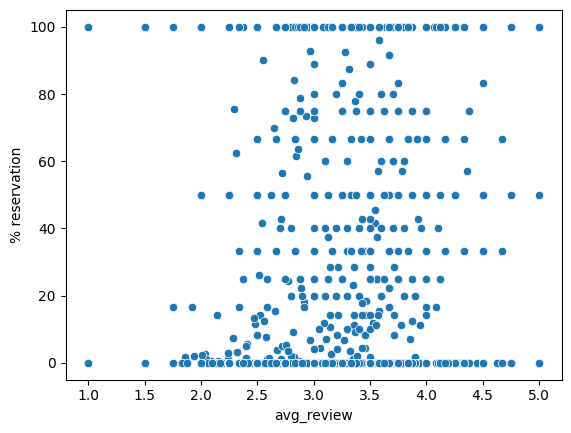

In [123]:
sns.scatterplot(data=name_df, x="avg_review", y="% reservation")

<AxesSubplot:xlabel='review', ylabel='Count'>

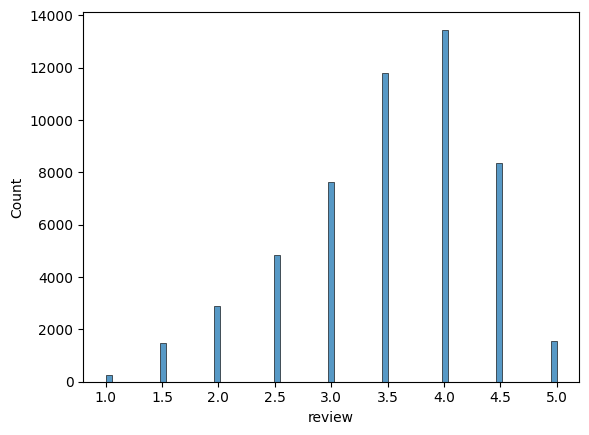

In [127]:
sns.histplot(data=food_df, x="review")

In [18]:
state_df = food_df.groupby(['state']).agg({'review' : 'mean', 'name' : 'count'}
                                            ).rename(columns = {'review' : 'avg_review','name' : 'total_outlets'}
                                                     ).sort_values(by=['avg_review'], ascending=False).reset_index()
state_df.head()

,state,avg_review,total_outlets
0,MT,5.000000,1
1,XMS,4.000000,1
2,CA,3.806704,1596
3,ID,3.643112,1684
4,LA,3.615427,4518


### Store categories and frequency

In [96]:
cat_df = food_df['categories'].apply(lambda x: pd.value_counts(x.split(", "))).sum(axis = 0).to_frame()
cat_df_2 = cat_df.reset_index()
cat_df_2.columns = ['category','count']
cat_df_2 = cat_df_2[(cat_df_2.category != 'food') & (cat_df_2.category != 'restaurants')]
cat_df_2.sort_values(by='count',ascending=False).head(20)

,category,count
13,nightlife,8738.0
7,sandwiches,8366.0
11,bars,8341.0
12,american (traditional),8139.0
30,pizza,7093.0
6,fast food,6472.0
18,breakfast & brunch,6239.0
50,american (new),6097.0
5,burgers,5636.0
67,mexican,4600.0


In [ ]:
# Example
r1=['food, cat, pig, dog','food, car, dog', 'dog, eagle']

df=pd.DataFrame(r1,columns=['text'])
df['text'].apply(lambda x: pd.value_counts(x.split(", "))).sum(axis = 0)

## 3. Load data into warehouse
https://cloud.google.com/bigquery/docs/samples/bigquery-load-table-dataframe 

In [ ]:
%pip install git+https://github.com/googleapis/python-bigquery-pandas.git

In [1]:
from google.cloud import bigquery
from pandas.io import gbq
import pandas_gbq

In [2]:
project_id = 'yelp_data_warehouse'
data_set_id = 'food_dataset'
table = 'test1'
table_id = '{}.{}.{}'.format(project_id, data_set_id, table)

In [ ]:
# Construct a BigQuery client object.
client = bigquery.Client()

job_config = bigquery.LoadJobConfig(
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

job = client.load_table_from_dataframe(
    food_df, table_id, job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

In [14]:
food_df.to_gbq(destination_table='food_dataset.test1',
               project_id='yelp_data_warehouse',
               if_exists='replace')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fpydata-google-auth.readthedocs.io%2Fen%2Flatest%2Foauth.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=W35tYPbTBRWt2D4F2NlD8AWAtMEU5i&access_type=offline
